In [1]:
import numbers
from collections import Counter
from scipy.stats import mode
from sklearn.utils import _safe_indexing
from sklearn.utils._param_validation import HasMethods, Interval, StrOptions
import pandas as pd
import numpy as np
import seaborn as sns    
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler  
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import GridSearchCV
from imblearn.metrics import geometric_mean_score
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import precision_recall_curve, roc_curve, f1_score
from xgboost import XGBClassifier
from sklearn.ensemble import ExtraTreesRegressor
import xgboost as xgb
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import tensorflow as tf
from tensorflow.keras import layers, models, datasets
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import train_test_split
from feature_engine.encoding import OneHotEncoder
from imblearn.under_sampling import EditedNearestNeighbours
from sklearn.metrics import (f1_score, roc_auc_score, average_precision_score, 
                             accuracy_score, matthews_corrcoef, recall_score, 
                             precision_score, confusion_matrix)

In [2]:
df = pd.read_csv('D:/My Thesis/data in spss/imputed_Extra_tree .csv')
df = df.drop('ID' ,axis = 1)

In [3]:
X=df.drop('Hospital_outcome',axis=1)
y=df['Hospital_outcome']

In [4]:
categorical_features = ['Sex','Digestive_underlying', 'Respiratory_underlying','Infectious_underlying','Fatness_underlying', 'Urinary_underlying',
'Diabete_underlying', 'Hypertension (HTN)','Heart_underlying','Nervous_underlying', 'Blooddisease_underlying','Opiate', 'Education', 
 'Urinary_Incontinence', 'Previous_recurrent', 'Noconsious', 'GCS','Receivingblood', 'Conciousness', 'Mode of Arrival', 'Awareness of time',
'Stroke type', 'Treatment_method', 'Pneumonia', 'Convulsions','Identifying people', 'Motionless','Respiratory', 'Heart', 'Edema', 'Bloody',
'Vision_impairment', 'Sensory', 'Headache', 'Blurred_Vision','Reduce_strength_limb', 'Lackofbalance', 'Weakness', 'Delirium','Skin_problems',
'Aphasia_and_Dysarthria', 'Cranial_nerve_Disorder','Paralyzed', 'Digestive_problems']  # Replace with your categorical column names
numeric_features = ['Age','RR','HR','systolic','LOS (days)']
df[categorical_features] = df[categorical_features].astype('category')

In [5]:
# Initial train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.3, random_state=101
)

# OneHotEncoder and StandardScaler

In [6]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
        ('num', StandardScaler(), numeric_features)
    ])

# IsolationForest

In [7]:
from sklearn.ensemble import IsolationForest
# Outlier detection (on training data only)
outlier_detector = IsolationForest(contamination=0.05, random_state=101)
outliers = outlier_detector.fit_predict(preprocessor.fit_transform(X_train))
inlier_mask = outliers != -1

In [8]:
# Apply outlier removal
X_train_clean, y_train_clean = X_train.iloc[inlier_mask], y_train.iloc[inlier_mask]

In [9]:
# Preprocess cleaned training data
X_train_preprocessed = preprocessor.transform(X_train_clean)
# Evaluate on test set
X_test_preprocessed = preprocessor.transform(X_test)

# Create  RandomForest Model

In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
#from sklearn.model_selection import GridSearchCV
rf_model = RandomForestClassifier(random_state=101)
param_grid = {
    'n_estimators': [64, 100, 150, 200],
    'max_depth': [10, 20, 30],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True, False],
    'oob_score': [True, False],
    'min_samples_split': [2],
    'min_samples_leaf': [1]
}

grid = GridSearchCV(rf_model, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
grid.fit(X_train_preprocessed, y_train_clean)

print("Best parameters:", grid.best_params_)


Fitting 5 folds for each of 96 candidates, totalling 480 fits
Best parameters: {'bootstrap': False, 'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 150, 'oob_score': False}


In [ ]:
# Train the final model with the best parameters
#rf_model = grid.best_estimator_

In [11]:
# Initialize Random Forest
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier(bootstrap= False,max_depth= 30,max_features= 'sqrt',min_samples_split=2,min_samples_leaf=1,
                                  n_estimators= 150,oob_score =False,random_state=101,verbose=1,n_jobs=-1)
rf_model.fit(X_train_preprocessed, y_train_clean)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    0.1s finished


RandomForestClassifier(bootstrap=False, max_depth=30, n_estimators=150,
                       n_jobs=-1, random_state=101, verbose=1)

In [12]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
rf_probs = rf_model.predict_proba(X_test_preprocessed)[:, 1]  # Probabilities for the positive class (class 1)
y_pred = rf_model.predict(X_test_preprocessed)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.


Accuracy: 0.8883495145631068
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.98      0.94       689
           1       0.79      0.44      0.56       135

    accuracy                           0.89       824
   macro avg       0.84      0.71      0.75       824
weighted avg       0.88      0.89      0.87       824

[[673  16]
 [ 76  59]]


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 150 out of 150 | elapsed:    0.0s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 150 out of 150 | elapsed:    0.0s finished


In [13]:
importance_scores = rf_model.feature_importances_
for i, score in enumerate(importance_scores):
    print(f"Feature {i}, Importance: {score:.4f}")

Feature 0, Importance: 0.0099
Feature 1, Importance: 0.0102
Feature 2, Importance: 0.0025
Feature 3, Importance: 0.0021
Feature 4, Importance: 0.0098
Feature 5, Importance: 0.0089
Feature 6, Importance: 0.0003
Feature 7, Importance: 0.0003
Feature 8, Importance: 0.0036
Feature 9, Importance: 0.0042
Feature 10, Importance: 0.0060
Feature 11, Importance: 0.0054
Feature 12, Importance: 0.0094
Feature 13, Importance: 0.0090
Feature 14, Importance: 0.0098
Feature 15, Importance: 0.0101
Feature 16, Importance: 0.0083
Feature 17, Importance: 0.0092
Feature 18, Importance: 0.0062
Feature 19, Importance: 0.0067
Feature 20, Importance: 0.0001
Feature 21, Importance: 0.0002
Feature 22, Importance: 0.0055
Feature 23, Importance: 0.0058
Feature 24, Importance: 0.0077
Feature 25, Importance: 0.0079
Feature 26, Importance: 0.0016
Feature 27, Importance: 0.0072
Feature 28, Importance: 0.0074
Feature 29, Importance: 0.0061
Feature 30, Importance: 0.0061
Feature 31, Importance: 0.0250
Feature 32, Import

In [14]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

In [15]:
# Convert confusion matrix to percentages
cm_percent = cm / cm.sum(axis=1)[:, np.newaxis] * 100

In [16]:
# Print confusion matrix (counts)
print("Confusion Matrix (Counts):")
print(cm)

Confusion Matrix (Counts):
[[673  16]
 [ 76  59]]


In [17]:
# Print confusion matrix (percentages)
print("\nConfusion Matrix (Percentages):")
print(cm_percent)


Confusion Matrix (Percentages):
[[97.6777939  2.3222061]
 [56.2962963 43.7037037]]


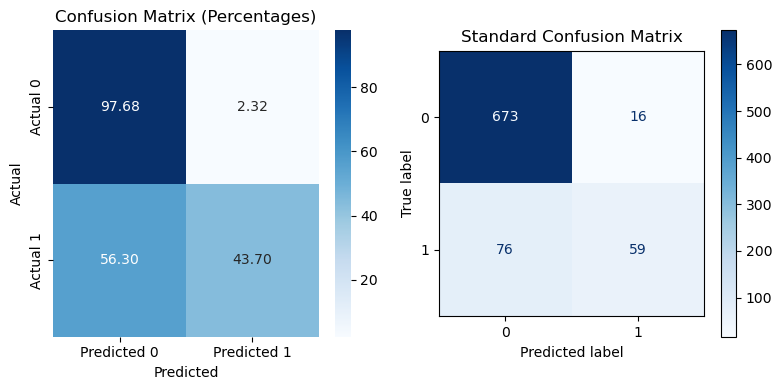

In [18]:
# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

# First plot: Percentage confusion matrix (Seaborn)
sns.heatmap(cm_percent, annot=True, fmt='.2f', cmap='Blues', 
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'],
            ax=ax1)
ax1.set_xlabel('Predicted')
ax1.set_ylabel('Actual')
ax1.set_title('Confusion Matrix (Percentages)')

# Second plot: Standard confusion matrix (Scikit-learn)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, 
                             display_labels=rf_model.classes_)
disp.plot(cmap='Blues', ax=ax2)
ax2.set_title('Standard Confusion Matrix')

# Adjust layout and display
plt.tight_layout()
plt.show()

In [19]:
# Calculate and print the error rate and the number of misclassifications
err = 1 - accuracy_score(y_test, y_pred)
n_miss = np.sum(y_pred != y_test)
print(f"Error Rate: {err}")
print(f"Number of Misclassifications: {n_miss}")

Error Rate: 0.11165048543689315
Number of Misclassifications: 92


In [20]:
from sklearn.metrics import classification_report
# Generate classification report 
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.98      0.94       689
           1       0.79      0.44      0.56       135

    accuracy                           0.89       824
   macro avg       0.84      0.71      0.75       824
weighted avg       0.88      0.89      0.87       824



In [21]:
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.metrics import matthews_corrcoef
# Calculate confusion matrix
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
# Calculate sensitivity and specificity
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)
mcc = matthews_corrcoef(y_test, y_pred)
g_mean = np.sqrt(sensitivity * specificity)
f1_score = f1_score(y_test, y_pred)
accuracy =accuracy_score(y_test, y_pred)
# Print results
print(f"Accuracy: {accuracy:.3f}")
print(f"Sensitivity (Recall): {sensitivity:.3f}")
print(f"Specificity: {specificity:.3f}")
print(f"G-mean: {g_mean:.3f}")
print(f"F1_measure: {f1_score:.3f}")
print(f"MCC: {mcc:.3f}")

Accuracy: 0.888
Sensitivity (Recall): 0.437
Specificity: 0.977
G-mean: 0.653
F1_measure: 0.562
MCC: 0.532


[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 150 out of 150 | elapsed:    0.0s finished


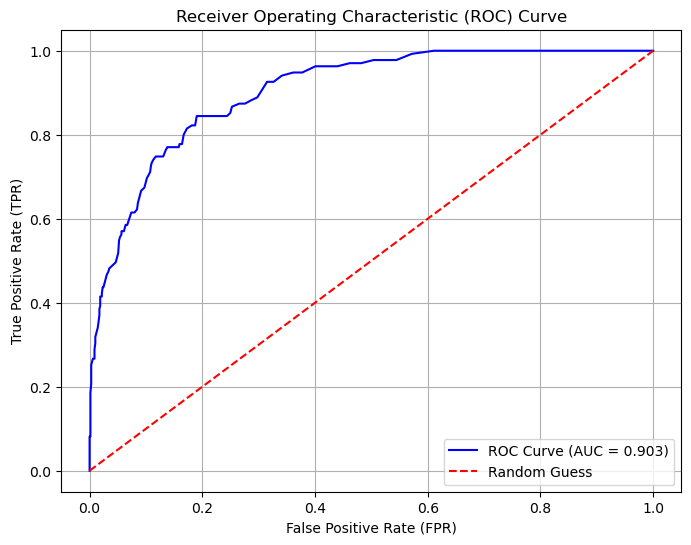

AUC: 0.903


In [24]:
from sklearn.metrics import roc_curve, roc_auc_score
# Get predicted probabilities for positive class
rf_probs = rf_model.predict_proba(X_test_preprocessed)[:, 1]  # Probabilities for the positive class (class 1)
fpr, tpr, thresholds = roc_curve(y_test, rf_probs, pos_label=rf_model.classes_[1])
# Calculate the AUC (Area Under the Curve)
auc = roc_auc_score(y_test, rf_probs)
# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc:.3f})', color='blue')
plt.plot([0, 1], [0, 1], linestyle='--', color='red', label='Random Guess')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.grid(True)
plt.show()
# Print the AUC score
print(f'AUC: {auc:.3f}')

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 150 out of 150 | elapsed:    0.0s finished


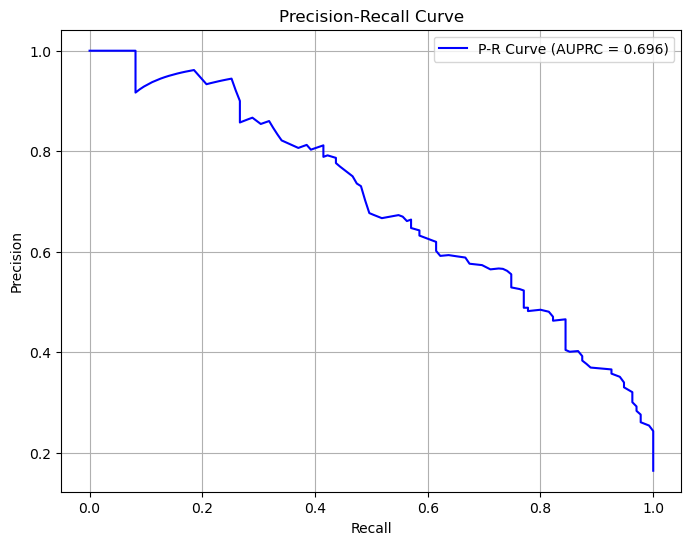

AUC: 0.696


In [26]:
from sklearn.metrics import precision_recall_curve, auc
# Get predicted probabilities for the positive class
rf_probs = rf_model.predict_proba(X_test_preprocessed)[:, 1]   # For scikit-learn models
# For Keras: y_probs = model.predict(X_test).flatten()
# Calculate P-R curve
precision, recall, thresholds = precision_recall_curve(y_test, rf_probs)
pr_auc = auc(recall, precision)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'P-R Curve (AUPRC = {pr_auc:.3f})',color='blue')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.show()
# Print the pr-auc score
print(f'AUC: {pr_auc:.3f}')

In [27]:
thresholds1 = np.linspace(0.01, 0.99, 100)  # 100 points between 0.01-0.99
thresholds2 = np.arange(0.01,1.0,0.1)

In [28]:
thresholds2

array([0.01, 0.11, 0.21, 0.31, 0.41, 0.51, 0.61, 0.71, 0.81, 0.91])

In [29]:
thresholds1

array([0.01      , 0.01989899, 0.02979798, 0.03969697, 0.04959596,
       0.05949495, 0.06939394, 0.07929293, 0.08919192, 0.09909091,
       0.1089899 , 0.11888889, 0.12878788, 0.13868687, 0.14858586,
       0.15848485, 0.16838384, 0.17828283, 0.18818182, 0.19808081,
       0.2079798 , 0.21787879, 0.22777778, 0.23767677, 0.24757576,
       0.25747475, 0.26737374, 0.27727273, 0.28717172, 0.29707071,
       0.3069697 , 0.31686869, 0.32676768, 0.33666667, 0.34656566,
       0.35646465, 0.36636364, 0.37626263, 0.38616162, 0.39606061,
       0.4059596 , 0.41585859, 0.42575758, 0.43565657, 0.44555556,
       0.45545455, 0.46535354, 0.47525253, 0.48515152, 0.49505051,
       0.50494949, 0.51484848, 0.52474747, 0.53464646, 0.54454545,
       0.55444444, 0.56434343, 0.57424242, 0.58414141, 0.5940404 ,
       0.60393939, 0.61383838, 0.62373737, 0.63363636, 0.64353535,
       0.65343434, 0.66333333, 0.67323232, 0.68313131, 0.6930303 ,
       0.70292929, 0.71282828, 0.72272727, 0.73262626, 0.74252

In [30]:
import numpy as np
from sklearn.metrics import f1_score, confusion_matrix  # Make sure to import these

# Your probabilities and thresholds
probabilities = rf_model.predict_proba(X_test_preprocessed)  # Ensure this outputs shape (n_samples, 2)
thresholds = np.linspace(0.01, 0.99, 100)  # 100 points between 0.01-0.99

# Initialize lists to store metrics
f1_scores = []
gmeans = []

for threshold in thresholds:
    # Apply threshold
    predictions = (probabilities[:, 1] >= threshold).astype(int)
    
    # Calculate metrics (using imported functions)
    current_f1 = f1_score(y_test, predictions)  # Now using the sklearn function
    tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    current_gmean = np.sqrt(sensitivity * specificity)
    
    # Store results
    f1_scores.append(current_f1)
    gmeans.append(current_gmean)
    
    print(f"Threshold: {threshold:.3f} | F1: {current_f1:.3f} | G-mean: {current_gmean:.3f}")

# Find optimal thresholds
optimal_f1_threshold = thresholds[np.argmax(f1_scores)]
optimal_gmean_threshold = thresholds[np.argmax(gmeans)]

print(f"\nOptimal F1 Threshold: {optimal_f1_threshold:.3f} (F1 = {max(f1_scores):.3f})")
print(f"Optimal G-mean Threshold: {optimal_gmean_threshold:.3f} (G-mean = {max(gmeans):.3f})")

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 150 out of 150 | elapsed:    0.0s finished


Threshold: 0.010 | F1: 0.368 | G-mean: 0.571
Threshold: 0.020 | F1: 0.391 | G-mean: 0.624
Threshold: 0.030 | F1: 0.411 | G-mean: 0.668
Threshold: 0.040 | F1: 0.430 | G-mean: 0.697
Threshold: 0.050 | F1: 0.449 | G-mean: 0.723
Threshold: 0.059 | F1: 0.458 | G-mean: 0.734
Threshold: 0.069 | F1: 0.481 | G-mean: 0.760
Threshold: 0.079 | F1: 0.489 | G-mean: 0.768
Threshold: 0.089 | F1: 0.511 | G-mean: 0.787
Threshold: 0.099 | F1: 0.515 | G-mean: 0.790
Threshold: 0.109 | F1: 0.522 | G-mean: 0.790
Threshold: 0.119 | F1: 0.528 | G-mean: 0.793
Threshold: 0.129 | F1: 0.541 | G-mean: 0.801
Threshold: 0.139 | F1: 0.549 | G-mean: 0.805
Threshold: 0.149 | F1: 0.547 | G-mean: 0.799
Threshold: 0.158 | F1: 0.559 | G-mean: 0.806
Threshold: 0.168 | F1: 0.574 | G-mean: 0.814
Threshold: 0.178 | F1: 0.583 | G-mean: 0.819
Threshold: 0.188 | F1: 0.592 | G-mean: 0.817
Threshold: 0.198 | F1: 0.598 | G-mean: 0.820
Threshold: 0.208 | F1: 0.603 | G-mean: 0.816
Threshold: 0.218 | F1: 0.595 | G-mean: 0.806
Threshold:

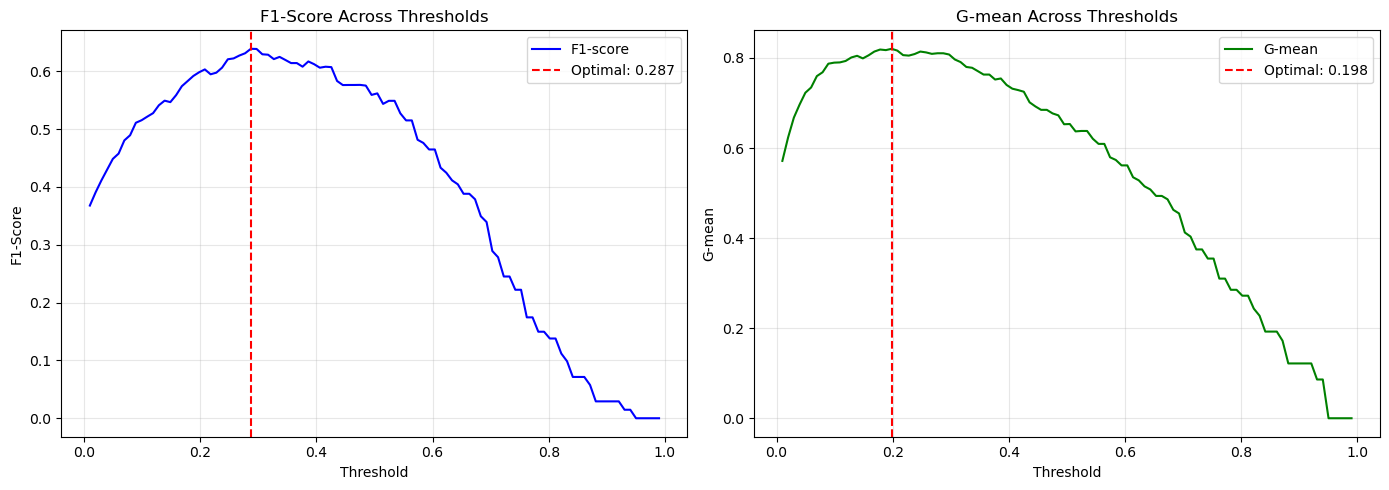

In [31]:
import matplotlib.pyplot as plt

# Create figure with two subplots side by side
plt.figure(figsize=(14, 5))

# F1-score plot (left subplot)
plt.subplot(1, 2, 1)  # 1 row, 2 columns, position 1
plt.plot(thresholds, f1_scores, color='blue', label='F1-score')
plt.axvline(x=optimal_f1_threshold, color='red', linestyle='--', 
            label=f'Optimal: {optimal_f1_threshold:.3f}')
plt.xlabel('Threshold')
plt.ylabel('F1-Score')
plt.title('F1-Score Across Thresholds')
plt.legend()
plt.grid(alpha=0.3)

# G-mean plot (right subplot)
plt.subplot(1, 2, 2)  # 1 row, 2 columns, position 2
plt.plot(thresholds, gmeans, color='green', label='G-mean')
plt.axvline(x=optimal_gmean_threshold, color='red', linestyle='--', 
            label=f'Optimal: {optimal_gmean_threshold:.3f}')
plt.xlabel('Threshold')
plt.ylabel('G-mean')
plt.title('G-mean Across Thresholds')
plt.legend()
plt.grid(alpha=0.3)

# Adjust layout and display
plt.tight_layout()
plt.show()

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 150 out of 150 | elapsed:    0.0s finished


RF Performance at Threshold = 0.287
--------------------------------------
G-mean: 0.810 
F1-score: 0.639 (Target: 0.562)
Accuracy: 0.863
MCC: 0.564
ROC AUC: 0.903
PR AUC: 0.696

Confusion Matrix:
[[611  78]
 [ 35 100]]


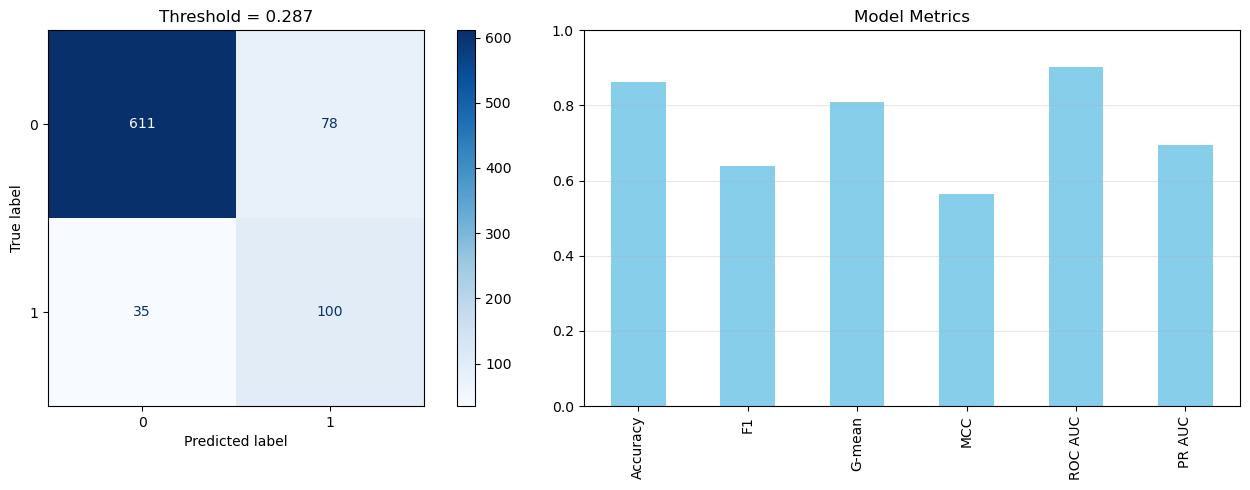


Threshold Optimization Insights:
- At threshold 0.287, we achieve maximum f1-measure 
- This threshold yields 74.1% recall and 88.7% specificity
- Compared to default 0.5 threshold:
  • f1-measure improvement: 0.080
  • Recall improvement: 0.304
  • G-mean improvement: 0.158
  • MCC improvement: 0.037
  • Accuracy improvement: -0.024


[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 150 out of 150 | elapsed:    0.0s finished


In [32]:
import numpy as np
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score,
    roc_auc_score, confusion_matrix, matthews_corrcoef,
    precision_recall_curve, auc
)

def evaluate_rf(rf_model, X_test_preprocessed, y_test, threshold=0.5):
    """Evaluate Random Forest model at specific threshold with all metrics"""
    # Get probabilities and predictions
    rf_probs = rf_model.predict_proba(X_test_preprocessed)[:, 1]
    y_pred = (rf_probs >= threshold).astype(int)
    
    # Calculate confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    
    # Compute all metrics
    metrics = {
        'Threshold': threshold,
        'Accuracy': accuracy_score(y_test, y_pred),
        'F1': f1_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'Specificity': tn / (tn + fp + 1e-8),
        'G-mean': np.sqrt(recall_score(y_test, y_pred) * (tn / (tn + fp + 1e-8))),
        'MCC': matthews_corrcoef(y_test, y_pred),
        'ROC AUC': roc_auc_score(y_test, rf_probs),
        'PR AUC': auc(*precision_recall_curve(y_test, rf_probs)[1::-1]),
        'Confusion Matrix': np.array([[tn, fp], [fn, tp]])
    }
    return metrics

# Now you can use the function
optimal_thresh = 0.287
results = evaluate_rf(rf_model, X_test_preprocessed, y_test, threshold=optimal_thresh)

# 3. Display results
print("RF Performance at Threshold = 0.287")
print("--------------------------------------")
print(f"G-mean: {results['G-mean']:.3f} ")
print(f"F1-score: {results['F1']:.3f} (Target: 0.562)")
print(f"Accuracy: {results['Accuracy']:.3f}")
print(f"MCC: {results['MCC']:.3f}")
print(f"ROC AUC: {results['ROC AUC']:.3f}")
print(f"PR AUC: {results['PR AUC']:.3f}")
print("\nConfusion Matrix:")
print(results['Confusion Matrix'])
# 4. Visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
# Confusion Matrix
ConfusionMatrixDisplay(results['Confusion Matrix']).plot(ax=ax1, cmap='Blues')
ax1.set_title(f'Threshold = {optimal_thresh:.3f}')

# Metrics Comparison
metrics = ['Accuracy', 'F1', 'G-mean', 'MCC', 'ROC AUC', 'PR AUC']
pd.Series(results).loc[metrics].plot.bar(ax=ax2, color='skyblue')
ax2.set_title('Model Metrics')
ax2.set_ylim(0, 1)
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# 5. Threshold Analysis Report
print("\nThreshold Optimization Insights:")
print(f"- At threshold 0.287, we achieve maximum f1-measure ")
print(f"- This threshold yields {results['Recall']:.1%} recall and {results['Specificity']:.1%} specificity")
print(f"- Compared to default 0.5 threshold:")
default_results = evaluate_rf(rf_model, X_test_preprocessed, y_test, threshold=0.5)
print(f"  • f1-measure improvement: {results['F1'] - default_results['F1']:.3f}")
print(f"  • Recall improvement: {results['Recall'] - default_results['Recall']:.3f}")
print(f"  • G-mean improvement: {results['G-mean'] - default_results['G-mean']:.3f}")
print(f"  • MCC improvement: {results['MCC'] - default_results['MCC']:.3f}")
print(f"  • Accuracy improvement: {results['Accuracy'] - default_results['Accuracy']:.3f}")

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 150 out of 150 | elapsed:    0.0s finished


RF Performance at Threshold = 0.198
--------------------------------------
G-mean: 0.820(Target: 0.653)
F1-score: 0.598 
Accuracy: 0.819
MCC: 0.525
ROC AUC: 0.903
PR AUC: 0.696

Confusion Matrix:
[[564 125]
 [ 24 111]]


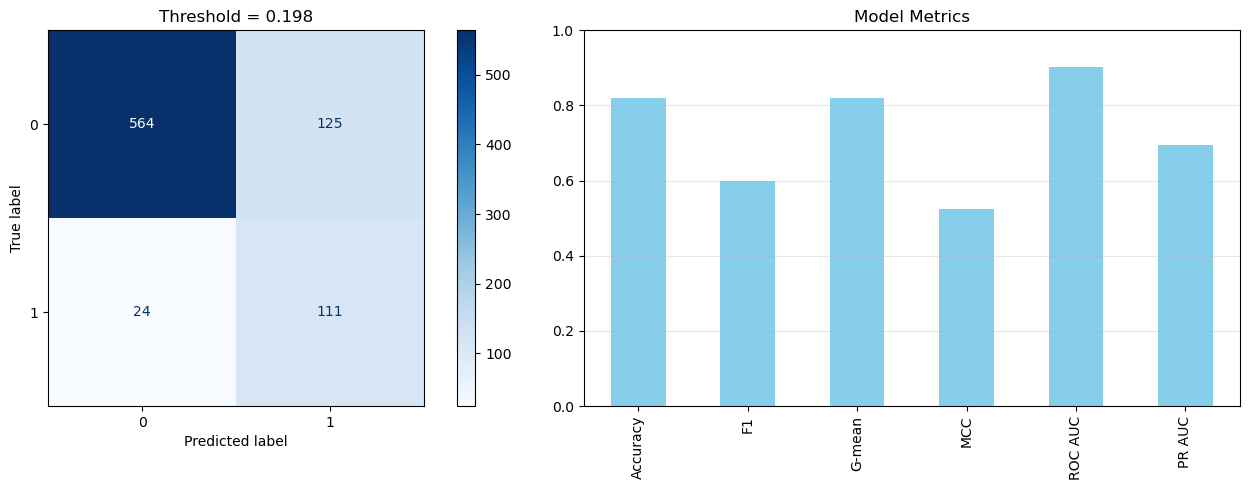


Threshold Optimization Insights:
- At threshold 0.198, we achieve maximum g-mean 
- This threshold yields 82.2% recall and 81.9% specificity
- Compared to default 0.5 threshold:
  • G-mean improvement: 0.168
  • Recall improvement: 0.385
  • F1-score improvement: 0.039
  • MCC improvement: -0.003
  • Accuracy improvement: -0.068


[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 150 out of 150 | elapsed:    0.0s finished


In [33]:
import numpy as np
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score,
    roc_auc_score, confusion_matrix, matthews_corrcoef,
    precision_recall_curve, auc
)


# Now you can use the function
optimal_thresh = 0.198
results = evaluate_rf(rf_model, X_test_preprocessed, y_test, threshold=optimal_thresh)

# 3. Display results
print("RF Performance at Threshold = 0.198")
print("--------------------------------------")
print(f"G-mean: {results['G-mean']:.3f}(Target: 0.653)")
print(f"F1-score: {results['F1']:.3f} ")
print(f"Accuracy: {results['Accuracy']:.3f}")
print(f"MCC: {results['MCC']:.3f}")
print(f"ROC AUC: {results['ROC AUC']:.3f}")
print(f"PR AUC: {results['PR AUC']:.3f}")
print("\nConfusion Matrix:")
print(results['Confusion Matrix'])
# 4. Visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
# Confusion Matrix
ConfusionMatrixDisplay(results['Confusion Matrix']).plot(ax=ax1, cmap='Blues')
ax1.set_title(f'Threshold = {optimal_thresh:.3f}')

# Metrics Comparison
metrics = ['Accuracy', 'F1', 'G-mean', 'MCC', 'ROC AUC', 'PR AUC']
pd.Series(results).loc[metrics].plot.bar(ax=ax2, color='skyblue')
ax2.set_title('Model Metrics')
ax2.set_ylim(0, 1)
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# 5. Threshold Analysis Report
print("\nThreshold Optimization Insights:")
print(f"- At threshold 0.198, we achieve maximum g-mean ")
print(f"- This threshold yields {results['Recall']:.1%} recall and {results['Specificity']:.1%} specificity")
print(f"- Compared to default 0.5 threshold:")
default_results = evaluate_rf(rf_model, X_test_preprocessed, y_test, threshold=0.5)
print(f"  • G-mean improvement: {results['G-mean'] - default_results['G-mean']:.3f}")
print(f"  • Recall improvement: {results['Recall'] - default_results['Recall']:.3f}")
print(f"  • F1-score improvement: {results['F1'] - default_results['F1']:.3f}")
print(f"  • MCC improvement: {results['MCC'] - default_results['MCC']:.3f}")
print(f"  • Accuracy improvement: {results['Accuracy'] - default_results['Accuracy']:.3f}")

# weighted

In [34]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from collections import Counter


In [35]:
# Compute class distribution
counter = Counter(y_train_clean)
class_weight = {0: counter[1] / counter[0], 1: 1.0}  # Inverse frequency for minority class

print(f"Estimated class_weight: {class_weight}")


Estimated class_weight: {0: 0.16848174247277387, 1: 1.0}


In [36]:
# Define parameter grid for class_weight and other hyperparameters
param_grid = {
    'class_weight': ['balanced', 'balanced_subsample', class_weight],
    'n_estimators': [64, 100, 150, 200],
    'max_depth': [3, 5,10, 20, 30, None],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True, False],
    'oob_score': [True, False],
    'min_samples_split': [2],
    'min_samples_leaf': [1]
}
# Define cross-validation strategy
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=101)

# Initialize RandomForestClassifier
model = RandomForestClassifier(random_state=101)


In [37]:
# Set up GridSearchCV
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring='roc_auc',
                    n_jobs=-1, cv=cv, verbose=1)

# Fit the grid search
grid_result = grid.fit(X_train_preprocessed, y_train_clean)

# Print the best parameters and score
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))


Fitting 10 folds for each of 576 candidates, totalling 5760 fits
Best: 0.887887 using {'bootstrap': True, 'class_weight': 'balanced', 'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 150, 'oob_score': True}


In [38]:
rf_model_w = RandomForestClassifier(bootstrap= True,max_depth= 30,max_features= 'sqrt',min_samples_split=2,min_samples_leaf=1,
                                  n_estimators= 150,oob_score =True,class_weight= 'balanced',n_jobs=-1, verbose=1)
rf_model_w.fit(X_train_preprocessed, y_train_clean)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    0.3s finished


RandomForestClassifier(class_weight='balanced', max_depth=30, n_estimators=150,
                       n_jobs=-1, oob_score=True, verbose=1)

In [39]:
y_pred_w = rf_model_w.predict(X_test_preprocessed)
rf_probs_w = rf_model_w.predict_proba(X_test_preprocessed)[:, 1]  # Probabilities for the positive class (class 1)

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 150 out of 150 | elapsed:    0.0s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 150 out of 150 | elapsed:    0.0s finished


In [40]:
# Evaluate best model XGBoost
accuracy = accuracy_score(y_test, y_pred_w)
print("\nOptimized Test Accuracy:",accuracy)


Optimized Test Accuracy: 0.8810679611650486


In [41]:
y_pred = rf_model_w.predict(X_test_preprocessed)
print(classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.99      0.93       689
           1       0.88      0.32      0.47       135

    accuracy                           0.88       824
   macro avg       0.88      0.65      0.70       824
weighted avg       0.88      0.88      0.86       824

Confusion Matrix:
 [[683   6]
 [ 92  43]]


[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 150 out of 150 | elapsed:    0.0s finished


In [42]:
from sklearn.metrics import f1_score, matthews_corrcoef, confusion_matrix
import numpy as np

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

mcc = matthews_corrcoef(y_test, y_pred)
g_mean = np.sqrt(sensitivity * specificity)
f1 = f1_score(y_test, y_pred)  # Use a different variable name
print(f"Accuracy: {accuracy:.3f}")
print(f"Sensitivity (Recall): {sensitivity:.3f}")
print(f"Specificity: {specificity:.3f}")
print(f"G-mean: {g_mean:.3f}")
print(f"MCC: {mcc:.3f}")
print(f"F1 Score: {f1:.3f}")

Accuracy: 0.881
Sensitivity (Recall): 0.319
Specificity: 0.991
G-mean: 0.562
MCC: 0.485
F1 Score: 0.467


[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 150 out of 150 | elapsed:    0.0s finished


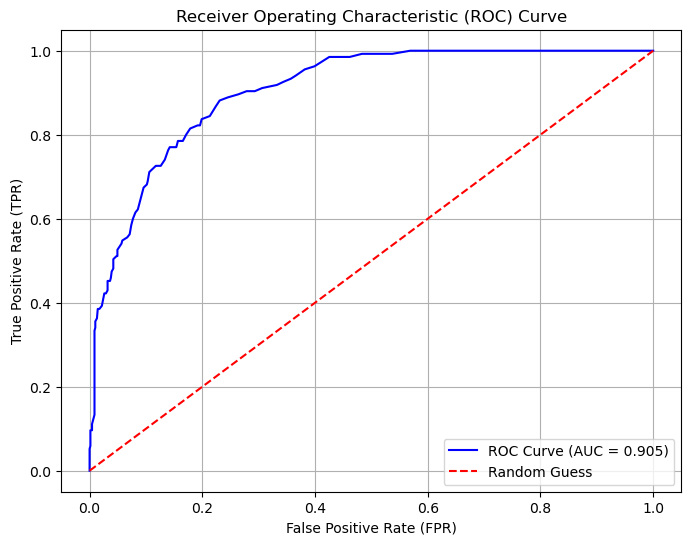

AUROC: 0.905


In [43]:
from sklearn.metrics import roc_curve, roc_auc_score
# Get predicted probabilities for positive class
rf_probs_w = rf_model_w.predict_proba(X_test_preprocessed)[:, 1]  # Probabilities for the positive class (class 1)
fpr, tpr, thresholds = roc_curve(y_test, rf_probs_w, pos_label=rf_model_w.classes_[1])
# Calculate the AUC (Area Under the Curve)
auc = roc_auc_score(y_test, rf_probs_w)
# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc:.3f})', color='blue')
plt.plot([0, 1], [0, 1], linestyle='--', color='red', label='Random Guess')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.grid(True)
plt.show()
# Print the AUC score
print(f'AUROC: {auc:.3f}')

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 150 out of 150 | elapsed:    0.0s finished


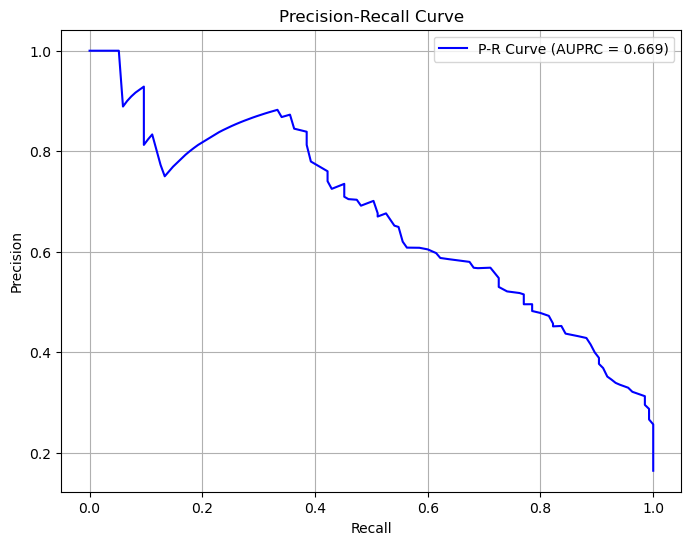

PRAUC: 0.669


In [44]:
from sklearn.metrics import precision_recall_curve, auc
# Get predicted probabilities for the positive class
rf_probs_w = rf_model_w.predict_proba(X_test_preprocessed)[:, 1]   # For scikit-learn models
# Calculate P-R curve
precision, recall, thresholds = precision_recall_curve(y_test, rf_probs_w)
pr_auc = auc(recall, precision)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'P-R Curve (AUPRC = {pr_auc:.3f})',color='blue')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.show()
# Print the pr-auc score
print(f'PRAUC: {pr_auc:.3f}')